# Using `AtomsTracker`

Here we show how to use `AtomsTracker` to automatically record operations performed on `ase.Atoms`

Installing AiiDA takes a few extra steps and require setting up an database normally (see [here](https://aiida.readthedocs.io/projects/aiida-core/en/latest/intro/get_started.html)).   
Here, for demostration only, we use a temporay profile with `SqliteTempBackend`. 

In [1]:
from aiida import load_profile, engine, orm, plugins
from aiida.manage.configuration import get_config
from aiida.storage.sqlite_temp import SqliteTempBackend

%load_ext aiida

profile = load_profile(
    SqliteTempBackend.create_profile(
        'myprofile',
        options={
            'warnings.development_version': False,
            'runner.poll.interval': 1
        },
        debug=False
    ),
    allow_switch=True
)
config = get_config()
config.add_profile(profile)
config.set_default_profile(profile.name)
profile

Profile<uuid='e7bd450e8df84717afd329b2001ac939' name='myprofile'>

In [2]:
from aiida_atoms import AtomsTracker
from ase.build import bulk


The `ase.Atoms` object models a atomic structure can be used in various ways. It is the centre piece to the `ase` ecosystem and used for constructing structure, data analysis and also calculations themselves.
Here, we focus the first use case - using `ase.Atoms` for constructing input structures used in various materials modelling workflows.
A common pattern is to start from a bulk structure, constructed manually or loaded from a online database (such as ICSD), and perform certain operations before it is used as inputs for first-principles calculations.

In this example, we start with a carbon in the diamond structure to create a defect supercell:

In [3]:
c2 = bulk("C")

create a supercell can be done with `.repeat`

In [4]:
supercell = c2.repeat((3,3,3))

note that `.repeat` is an out of place operation - a new `ase.Atoms` object is created 

In [5]:
print(supercell)

Atoms(symbols='C54', pbc=True, cell=[[0.0, 5.3549999999999995, 5.3549999999999995], [5.3549999999999995, 0.0, 5.3549999999999995], [5.3549999999999995, 5.3549999999999995, 0.0]])


Let's remove an atom from it:

In [6]:
supercell.pop(0)
print(supercell)

Atoms(symbols='C53', pbc=True, cell=[[0.0, 5.3549999999999995, 5.3549999999999995], [5.3549999999999995, 0.0, 5.3549999999999995], [5.3549999999999995, 5.3549999999999995, 0.0]])


New our supercell has only 53 atoms, we write it to the disk

In [7]:
supercell.write("C_Vac_c.vasp")

The structure can be read into a different python session for further operation or used for calculation.

In [8]:
import ase.io
supercell_loaded = ase.io.read("C_Vac_c.vasp")

However, if the file `C_Vac_c.vasp` itself does not contain any history about how it was made, e.g  which structure was used as the bulk and which atom was remove.

Let put the `AtomsTracker` into use:

In [9]:
tracker = AtomsTracker(c2)
tracker.label = "C2 Primitive"
defect_cell = tracker.repeat((3,3,3))
defect_cell.pop(0)
defect_cell.rattle(stdev=0.05, seed=11)
defect_cell.label = "C2 Rattled supercell"

now both `tracker` and `supercell` are `AtomsTracker` objects: 

In [10]:
print(tracker, defect_cell)

<aiida_atoms.tracker.AtomsTracker object at 0x7fe28876f520> <aiida_atoms.tracker.AtomsTracker object at 0x7fe26908e880>


An `AtomsTracker` is just an `ase.Atoms` object plus an `aiida.orm.StructureData` with methods of `ase.Atoms` attached.

In [11]:
print(tracker.atoms)

print(tracker.node.__repr__())

Atoms(symbols='C2', pbc=True, cell=[[0.0, 1.785, 1.785], [1.785, 0.0, 1.785], [1.785, 1.785, 0.0]])
<StructureData: uuid: 9d989409-39eb-4357-a31a-786e6409a3e7 (pk: 2)>


In [12]:
print(defect_cell.atoms)

print(defect_cell.node.__repr__())

Atoms(symbols='C53', pbc=True, cell=[[0.0, 5.3549999999999995, 5.3549999999999995], [5.3549999999999995, 0.0, 5.3549999999999995], [5.3549999999999995, 5.3549999999999995, 0.0]], masses=...)
<StructureData: uuid: b584ed8d-f67e-4317-8b04-56b8de536e7e (pk: 11)>


Now the `supercell` includes the history show how it was made

In [13]:
calc_pop = defect_cell.node.base.links.get_incoming().one()
print(calc_pop)

LinkTriple(node=<CalcFunctionNode: uuid: 90eecd91-80f4-4b36-a0b5-dbf6d6f14d08 (pk: 10) (ase.atoms.rattle)>, link_type=<LinkType.CREATE: 'create'>, link_label='result')


`LinkTriple` is an object to represent a link between two nodes. Here, one is the output strucutre `supercell.node` and the other is a `Calculation` that create the output.

We can also check what are the inputs used in this calculation:

In [14]:
calc_func = calc_pop.node
calc_func.base.links.get_incoming().all()

[LinkTriple(node=<Float: uuid: aa9dfd6c-950e-4a51-bfb3-b48022cbc8ba (pk: 8) value: 0.05>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='stdev'),
 LinkTriple(node=<Int: uuid: 47669895-8b61-4e36-8a74-e0e085802921 (pk: 9) value: 11>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='seed'),
 LinkTriple(node=<StructureData: uuid: da970742-1231-4b80-9cbc-9cb48477616f (pk: 7)>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='node')]

Let's visualise the provenance.

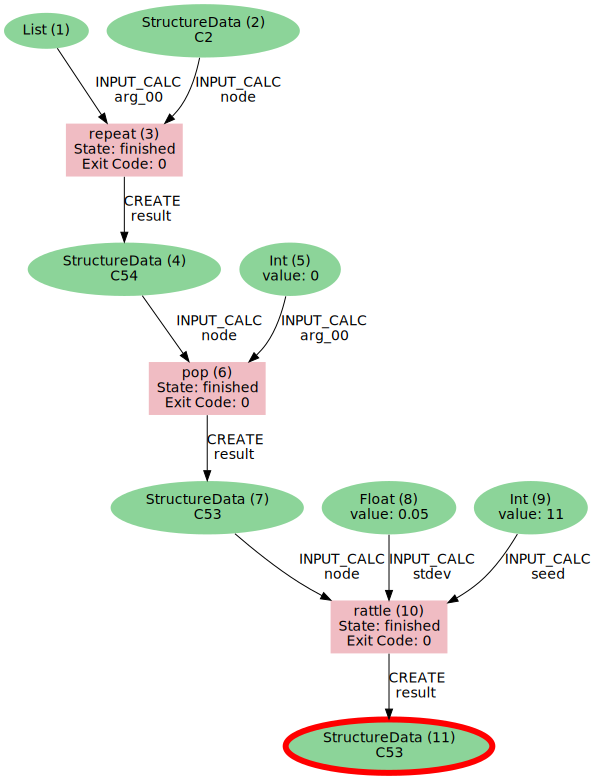

In [15]:
from aiida.tools.visualization import Graph
def view_provenance(node, **kwargs):
    graph = Graph()
    graph.recurse_ancestors(node, annotate_links="both")
    return graph.graphviz
def view_descendants(node, **kwargs):
    graph = Graph()
    graph.recurse_descendants(node, annotate_links="both", include_process_inputs=True)
    return graph.graphviz
view_provenance(defect_cell.node)

Great, we now have a full history of how our defect supercell is created.  
`note`{The links are labeled with the names of the keyword arguments, but the positional arguments are labeld with *arg_00*.}

Now let'ts create more defect structures, note the `pop` operation does an inplace mutation of the `supercell`.
Since the intermeidate resutls are all store, we can rewind it back without problem.

In [16]:
perfect_supercell = AtomsTracker(orm.load_node(4))
defect2 = AtomsTracker(perfect_supercell)
defect2.pop(1)

Atom('C', [0.8925, 0.8925, 0.8925], mass=12.011)

Note that the `defect2` is returned is actually the same `atoms` - this is different from the `ase.Atoms.pop` which returns the poped atom.
The tracker has this behaviour to allow operations to be chained in a single line. 
But for out of place operation, such as `repeat` or `sort` this the returned tracker will be a new object.

In [17]:
sorted_defect2 = defect2.sort()
sorted_defect2 is defect2

False

Another useful information is to check what are the descendants of a root node.

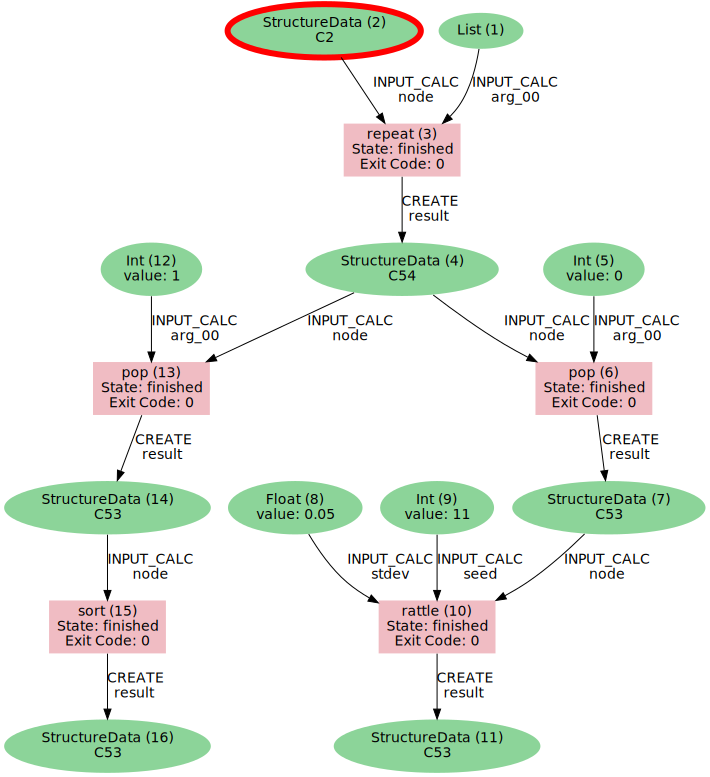

In [18]:
view_descendants(tracker.node)

In [19]:
tracker.node.base